# Figure 5: Quantitative analysis of trans-splicing prevalence

**Summary:**<br>

This notebook compiles the scripts that were used to generate the Figure 5.

- **Panel a:** Measure of ratio SL/Hairpin.

- **Panel b:** Proportion of trans-spliced gene with various SL thresholds.

- **Panel c:** Read coverage for SL, Hairpin and Unidentified genes.


---
<br>



## Import libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

## Settings for saving figures as pdf

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [3]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

## Opening Dataset file

In [4]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

In [5]:
genes_start = pd.read_csv(f'{path}/start_positions_stats.tsv', sep='\t')

---

<br>

# Panel a: Measure of SL/Hairpin ratio

In [6]:
# for each gene with the select the main oberserved TSS (start position most expressed)
# For ambiguitous positions (= same amount of reads), we select positions for which we observed more trans-splicing   
main_tss = genes_start[genes_start['total']>0].sort_values(['total','SL'], ascending=False).groupby(['gene']).head(1).reset_index(drop=True)

# Measure ratio based on SL and Hairpin genes at each position
main_tss['SL/HAIRPIN_ratio'] = round(main_tss['SL'] / (main_tss['HAIRPIN']+main_tss['SL']) * 100, 2)

In [7]:
# Measure number of genes in each categories

sl_genes = main_tss[(main_tss['SL/HAIRPIN_ratio']>=50) & (main_tss['%UNIDENTIFIED'] != 100)]
print(f'SL genes: {len(sl_genes)}')

hairpin_genes = main_tss[(main_tss['SL/HAIRPIN_ratio']<50) & (main_tss['%UNIDENTIFIED'] != 100)]
print(f'HAIRPIN genes: {len(hairpin_genes)}')

unidentified_genes = main_tss[main_tss['%UNIDENTIFIED']==100]
print(f'UNIDENTIFIED genes: {len(unidentified_genes)}')


# Measure percentages for both categories without accoounting for unidentified genes
print('----------')
sl_percent = round(len(sl_genes)/(len(sl_genes)+len(hairpin_genes))*100, 2)
print(f'SL genes: {sl_percent}%')

hairpin_percent = round(100-sl_percent, 2)
print(f'HAIRPIN genes: {hairpin_percent}%')

SL genes: 11846
HAIRPIN genes: 2985
UNIDENTIFIED genes: 3055
----------
SL genes: 79.87%
HAIRPIN genes: 20.13%


In [8]:
nb_sl = len(sl_genes[sl_genes.total>=20])
nb_hairpin = len(hairpin_genes[hairpin_genes.total>=20])

sl_percent = round(nb_sl/(nb_sl+nb_hairpin)*100, 2)
hairpin_percent = round(100-sl_percent, 2)

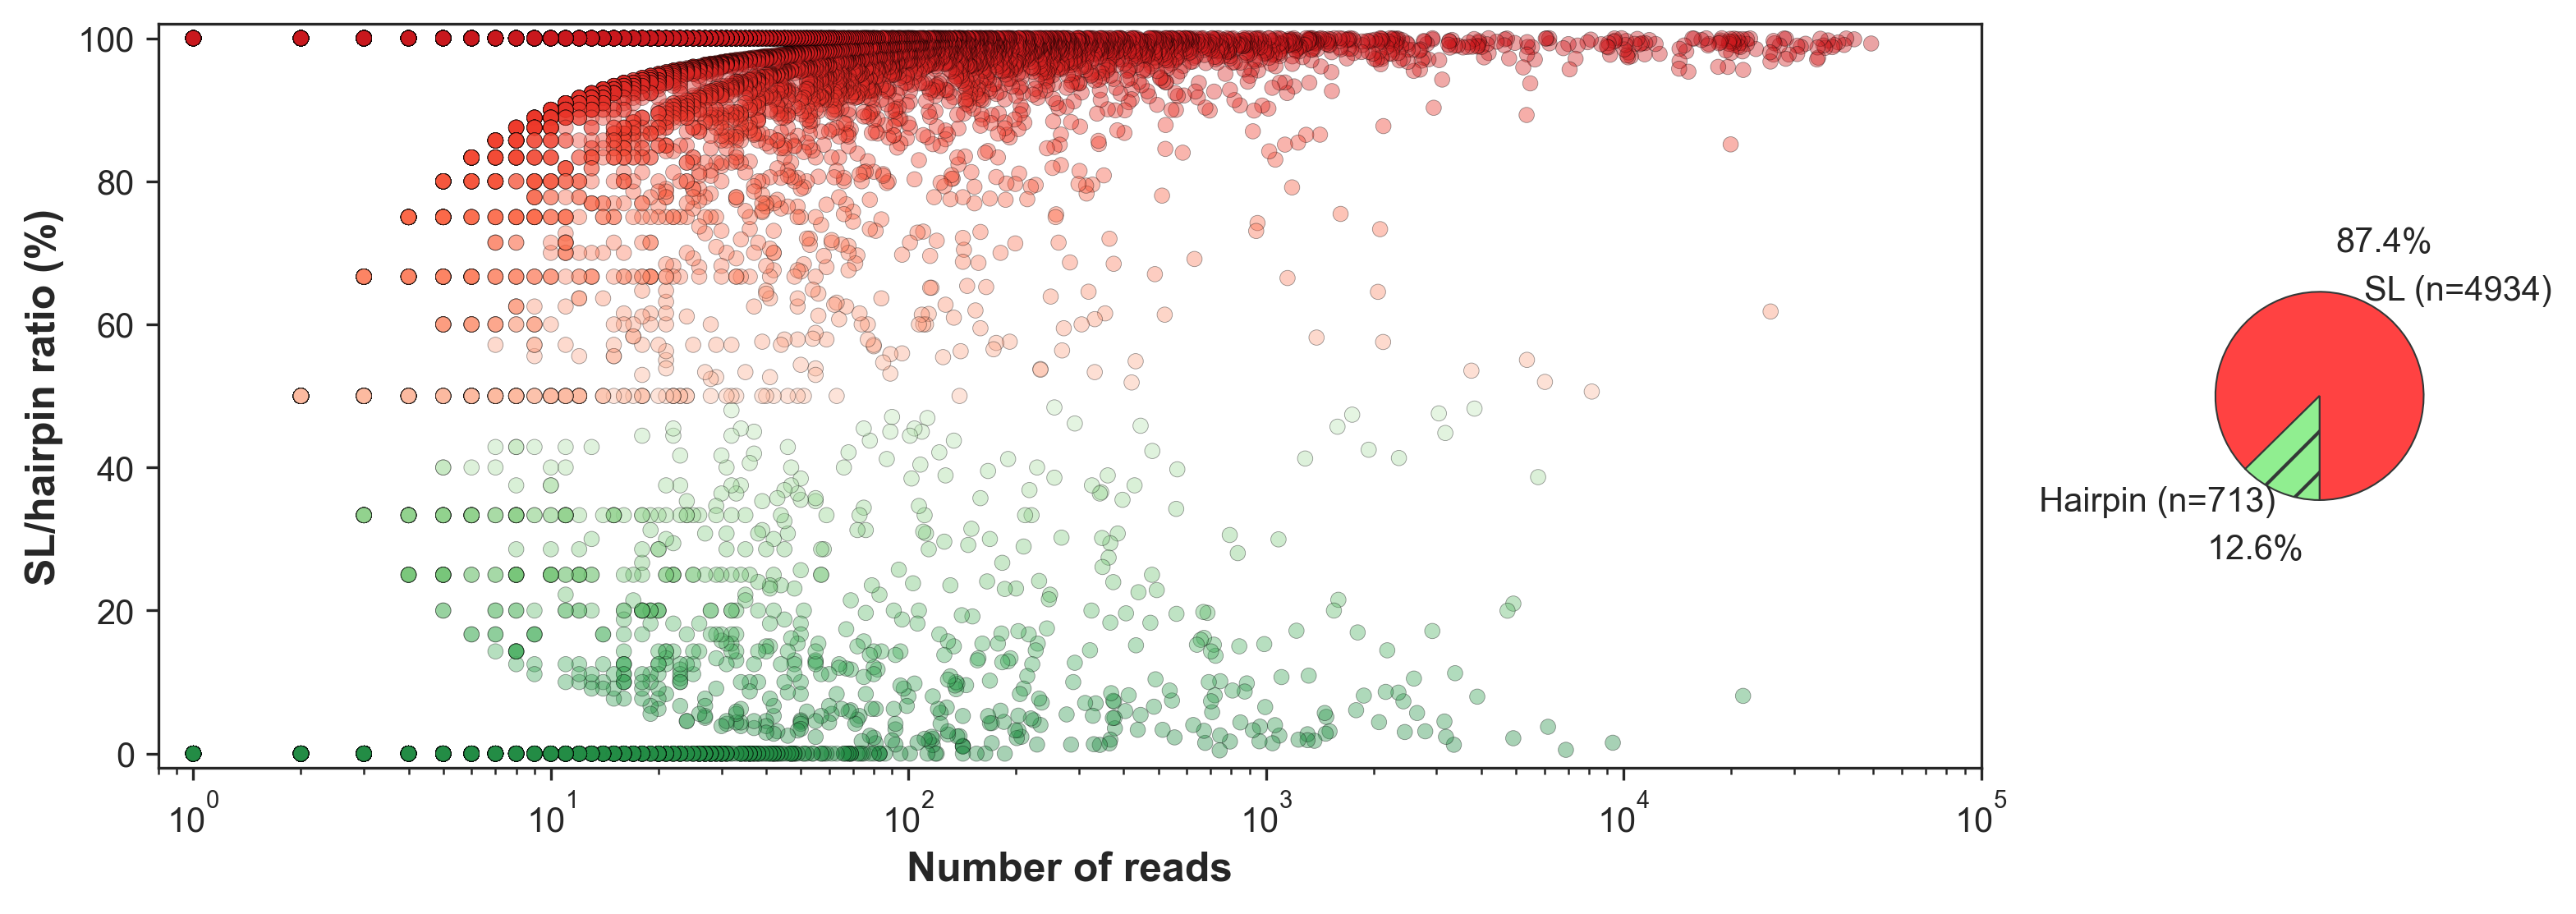

In [9]:
%matplotlib inline

# initialize plot
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(12,4), dpi=300, nrows=1, ncols=2, gridspec_kw={'width_ratios': [7,1]})

### create custom colormap
top = cm.get_cmap('Greens_r', 128)
bottom = cm.get_cmap('Reds', 128)
newcolors = np.vstack((top(np.linspace(0.25, 0.75, 128)), bottom(np.linspace(0.25, 0.75, 128))))
newcmp = ListedColormap(newcolors, name='GreenRed')


### plot LEFT panel (scatter plot)

ax[0].scatter(main_tss['total'], main_tss['SL/HAIRPIN_ratio'], s=20, c=main_tss['SL/HAIRPIN_ratio'], cmap=newcmp, edgecolor='k', linewidth=0.2, alpha=0.4)

ax[0].set_xscale('log')
ax[0].set_ylim(bottom=-2, top=102)
ax[0].set_xlim(left=0.8, right=10**5)
ax[0].set_xlabel("Number of reads", weight='bold', size=12)
ax[0].set_ylabel('SL/hairpin ratio (%)', weight='bold', size=12)


### plot RIGHT panel (scatter plot)

labels = [f'SL (n={nb_sl})', f'Hairpin (n={nb_hairpin})']
colors = ['#ff4242', 'lightgreen']
data = [sl_percent, hairpin_percent]

p = ax[1].pie(data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=270, pctdistance=1.6, 
            wedgeprops={'linewidth': 0.5, 'linestyle': 'solid', 'edgecolor':'#343837','antialiased': True})

hatches = ['//' if value == hairpin_percent else '' for value in data]
for i in range(len(p[0])):
    p[0][i].set(hatch = hatches[i])


# save as png
plt.savefig('Fig5.a-SL_versus_Hairpin_usage.png', dpi=800, bbox_inches='tight')

<font size="4">**Figure 5.a:**<br></font>
For each gene we measured the ratio of SL/Hairpin reads at the most expressed starting mRNA position. For genes with at least 20 reads at their most expressed position we represent the proportion of genes that have a majority of SL reads. 

<br>

# panel b: Proportion of trans-spliced gene with various SL thresholds.

In [10]:
threshold_value = []
nb_SL_genes = []
nb_hairpin_genes = []

for threshold in range(0, 105, 5):
    
    threshold_value.append(threshold)
    
    if threshold == 0:
        _sl_genes = len(main_tss[(main_tss['total']>=20) & (main_tss['SL/HAIRPIN_ratio']>0) & (main_tss['%UNIDENTIFIED'] != 100)])
        _hairpin_genes = len(main_tss[(main_tss['total']>=20) & (main_tss['SL/HAIRPIN_ratio']==0) & (main_tss['%UNIDENTIFIED'] != 100)])
    
    else:
        _sl_genes = len(main_tss[(main_tss['total']>=20) & (main_tss['SL/HAIRPIN_ratio']>=threshold) & (main_tss['%UNIDENTIFIED'] != 100)])
        _hairpin_genes = len(main_tss[(main_tss['total']>=20) & (main_tss['SL/HAIRPIN_ratio']<threshold) & (main_tss['%UNIDENTIFIED'] != 100)])
        
    nb_SL_genes.append(_sl_genes)
    nb_hairpin_genes.append(_hairpin_genes)
    
classification = pd.DataFrame(dict(THRESHOLD=threshold_value, SL=nb_SL_genes, HAIRPIN=nb_hairpin_genes)).set_index('THRESHOLD')

classification['%SL'] = round(classification['SL']/(classification['SL']+classification['HAIRPIN'])*100, 2)
classification['%HAIRPIN'] = round(classification['HAIRPIN']/(classification['SL']+classification['HAIRPIN'])*100, 2)

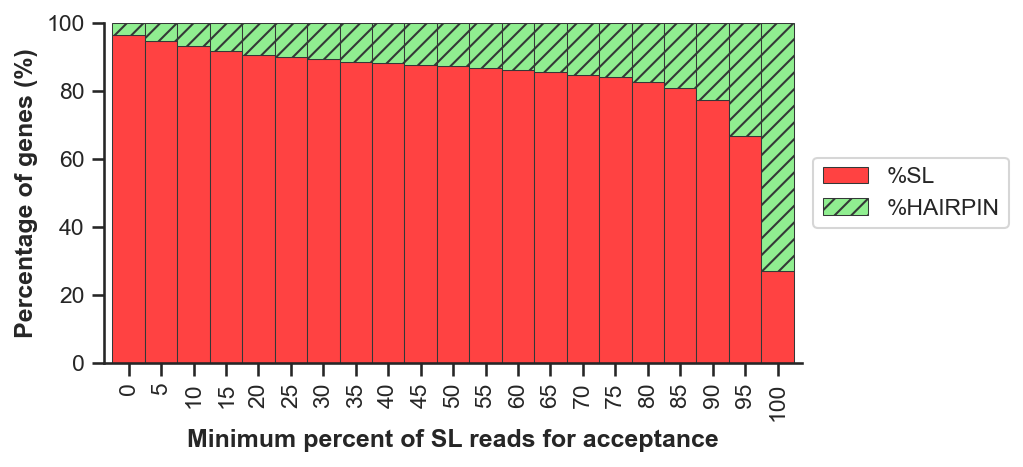

In [11]:
%matplotlib inline

# Plot settings
sns.set(rc={"figure.dpi":150})
sns.set_style('ticks')

# Create bar plot
ax = classification[['%SL','%HAIRPIN']].plot(kind='bar', stacked=True, color=['#ff4242', 'lightgreen'],
                         width=1, linewidth=0.5, edgecolor='#343837', figsize=(6,3))

# add patch to green bar
bars = ax.patches
patterns = ('', '///')
hatches = [p for p in patterns for i in range(len(classification))]
for bar, hatch in zip(bars, hatches):
    bar.set_hatch(hatch)

sns.despine(top=True, right=True)

# Show legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Axis settings
plt.xlabel('Minimum percent of SL reads for acceptance', weight='bold')
plt.ylabel('Percentage of genes (%)', weight='bold')
plt.ylim(0, 100)

plt.savefig('Fig5.b-Evolution_of_classification_based_on_SL_threshold_used.png', dpi=800, bbox_inches='tight')

<font size="4">**Figure 5.b:**<br></font>
Proportion of trans spliced gene with various SL thresholds. 

<br>

# Panel c: Read coverage for SL, Hairpin and Unidentified genes

In [12]:
sl_genes = sl_genes.assign(CATEGORY = 'SL')
hairpin_genes = hairpin_genes.assign(CATEGORY = 'HAIRPIN')
unidentified_genes = unidentified_genes.assign(CATEGORY = 'UNIDENTIFIED')

main_tss_cat = pd.concat([sl_genes, hairpin_genes, unidentified_genes])

print('SL genes: ', len(sl_genes))
print('Hairpin genes: ', len(hairpin_genes))
print('Unidentified genes: ', len(unidentified_genes))

SL genes:  11846
Hairpin genes:  2985
Unidentified genes:  3055


In [13]:
main_tss_cat

,gene,position,total,SSP,%SSP,SL,HAIRPIN,UNIDENTIFIED,%SL,%HAIRPIN,%UNIDENTIFIED,SL1_variants,SL2_variants,SL2_ratio,SL/HAIRPIN_ratio,CATEGORY
0,F54D7.7,4790292,49267,796,1.62,43473,326,5468,88.24,0.66,11.10,19853,30,0.001509,99.26,SL
1,F36A2.6,8816193,44164,1218,2.76,43443,64,657,98.37,0.14,1.49,19176,409,0.020883,99.85,SL
2,F37C12.9,7179594,41973,798,1.90,41886,16,71,99.79,0.04,0.17,20847,4,0.000192,99.96,SL
3,Y48B6A.2,14155280,41397,944,2.28,38714,367,2316,93.52,0.89,5.59,18079,34,0.001877,99.06,SL
4,F40F8.10,11126362,39871,1026,2.57,37960,223,1688,95.21,0.56,4.23,16605,212,0.012606,99.42,SL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17880,ZK938.3,9834059,1,0,0.00,0,0,1,0.00,0.00,100.00,0,0,NaN,NaN,UNIDENTIFIED
17881,ZK938.6,9844304,1,0,0.00,0,0,1,0.00,0.00,100.00,0,0,NaN,NaN,UNIDENTIFIED
17882,ZK945.6,10106256,1,0,0.00,0,0,1,0.00,0.00,100.00,0,0,NaN,NaN,UNIDENTIFIED
17883,ZK945.9,10116219,1,0,0.00,0,0,1,0.00,0.00,100.00,0,0,NaN,NaN,UNIDENTIFIED


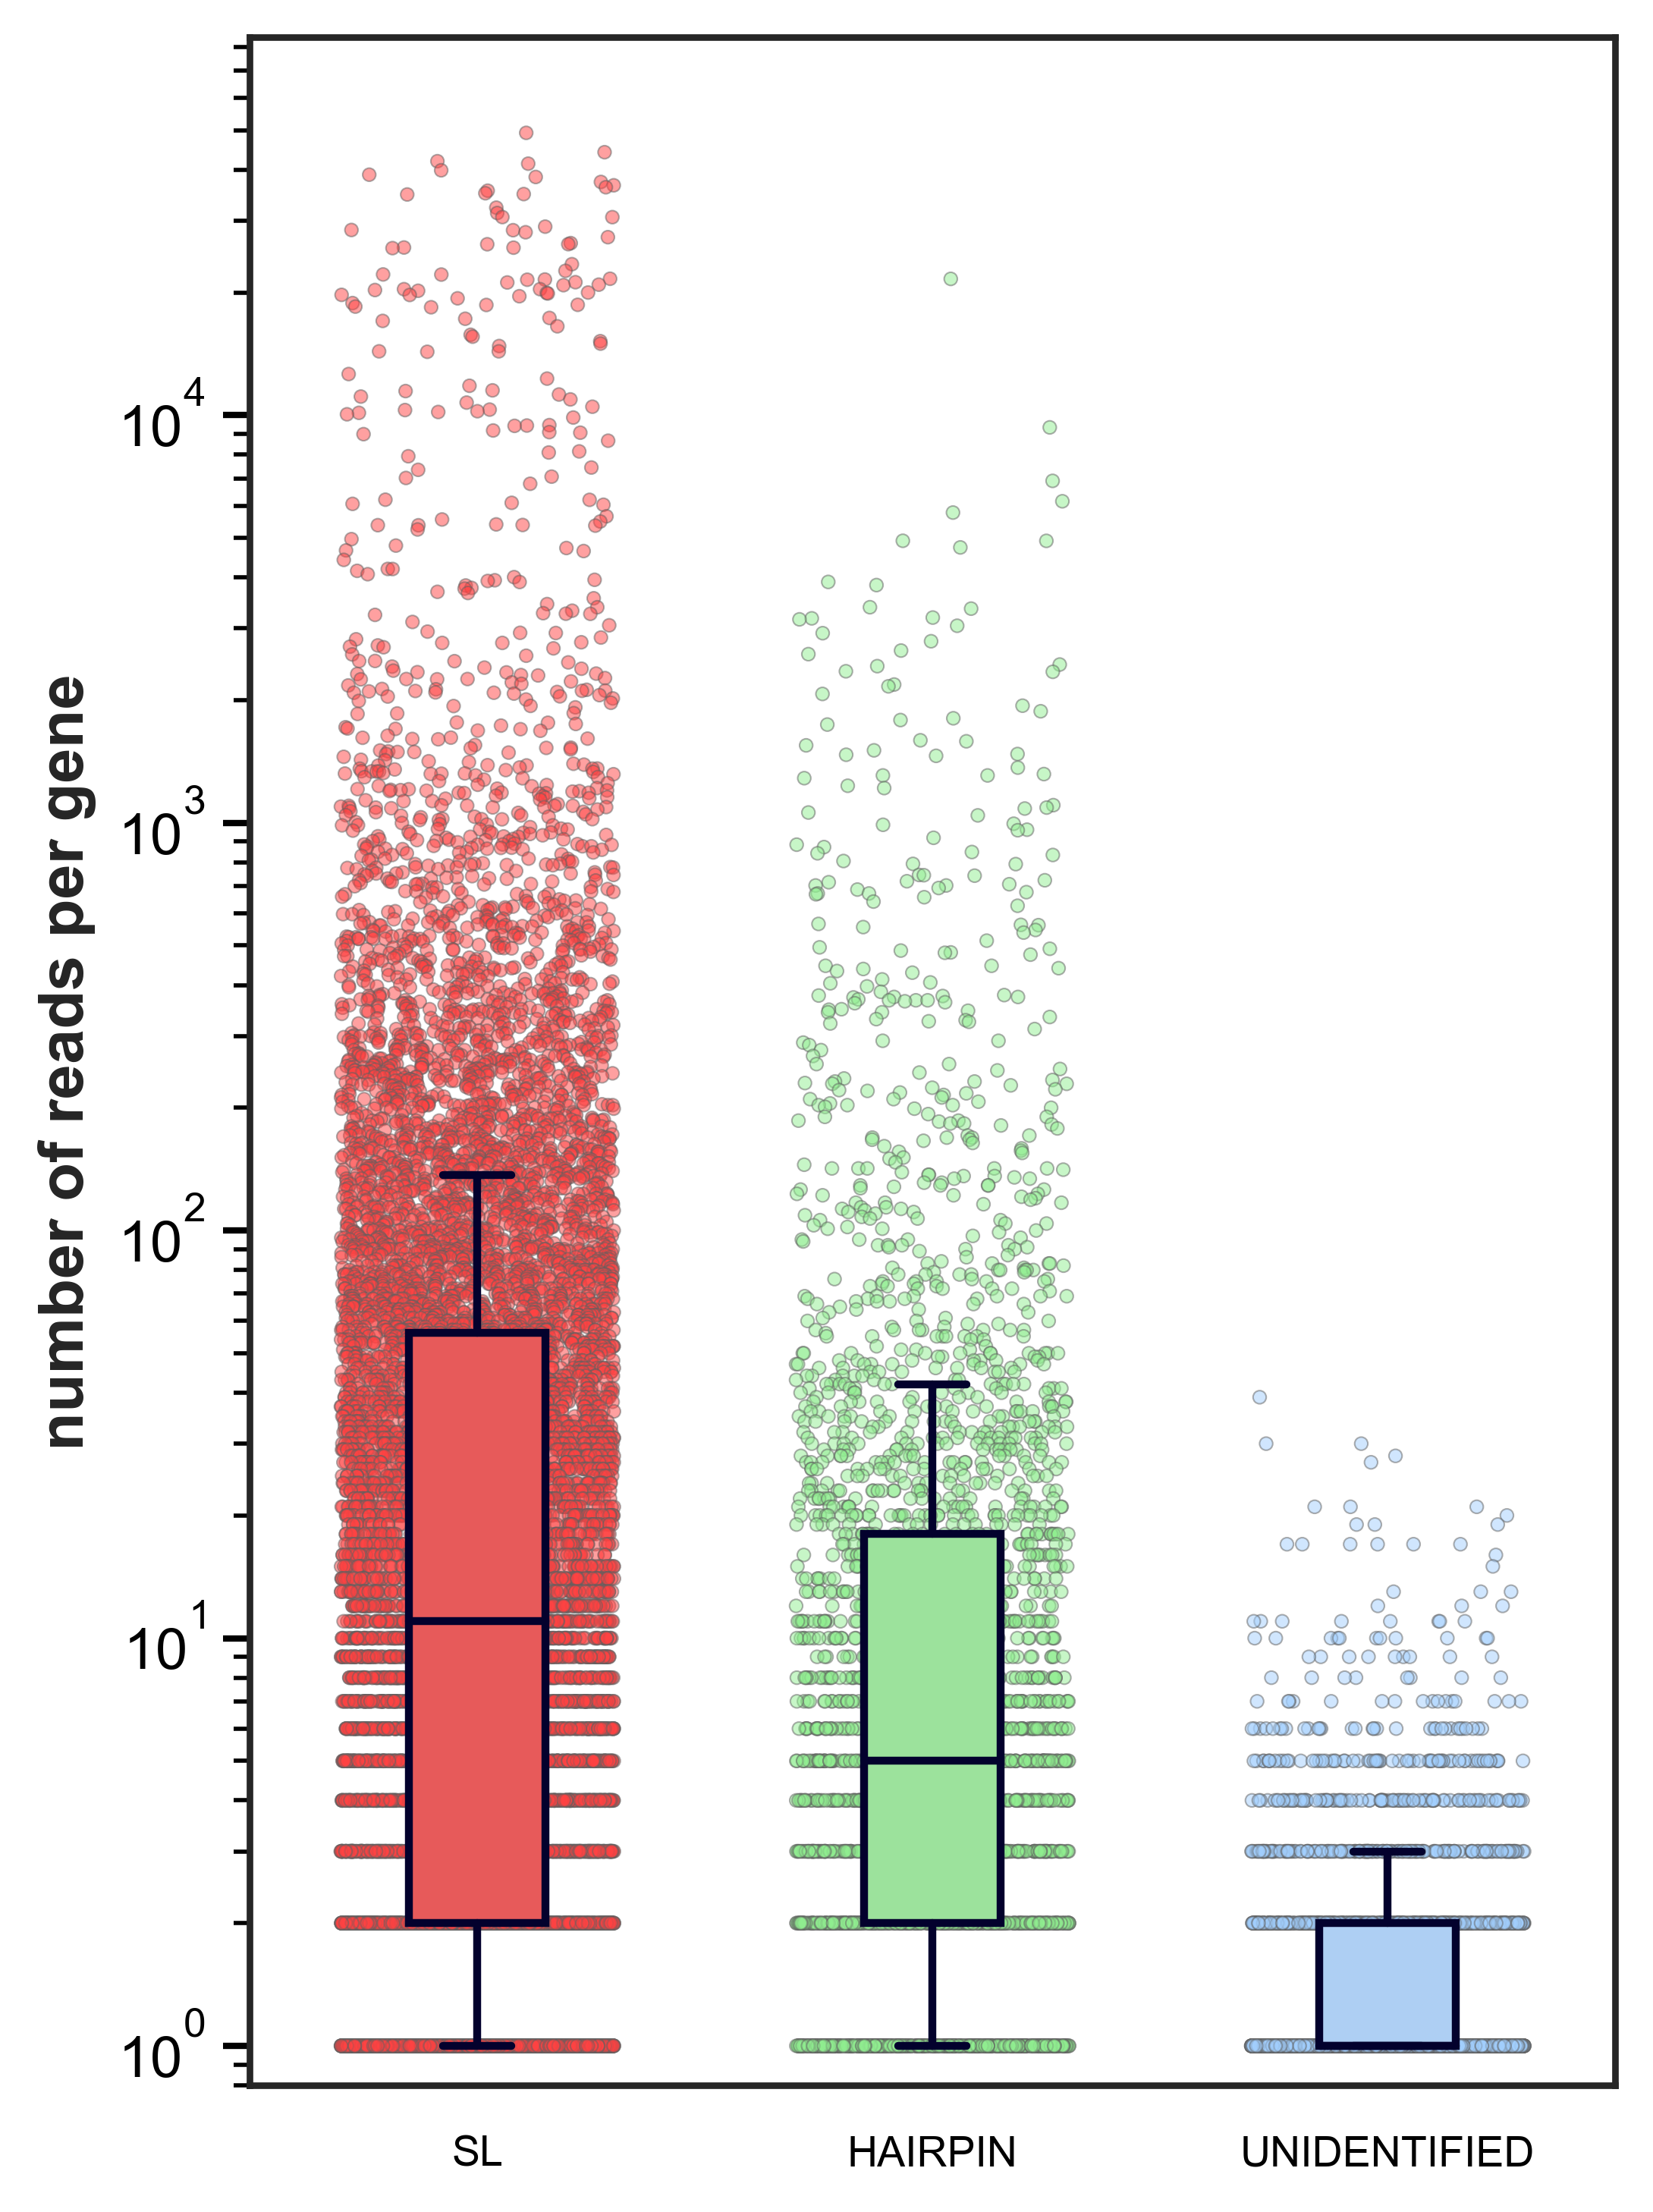

In [14]:
# create figure
%matplotlib inline
fig = plt.figure(figsize=(4, 6), dpi=500)

# create a rectangle for the new axis
rect = 0.1 ,0.1, 0.9, 0.9

# create a new axis
log_ax = fig.add_axes(rect)

# log first
log_ax.set_yscale("log")

# Strip plot
col = ['#ff4242', 'lightgreen', '#a2cffe']

ax = sns.stripplot(x='CATEGORY', y='total', data=main_tss_cat, palette=col, linewidth=0.3, jitter=0.3, size=2.5, alpha=0.5, zorder=0)

# Boxplot
PROPS = {'boxprops':{'edgecolor':'#03012d'},'medianprops':{'color':'#03012d'},'whiskerprops':{'color':'#03012d'},'capprops':{'color':'#03012d'}}
sns.boxplot(x='CATEGORY', y='total', data=main_tss_cat, fliersize=0, palette=col, width=0.3, zorder=1, **PROPS )

# Plot settings
log_ax.tick_params(direction='out', length=6, width=2, colors='black', grid_alpha=0.5, bottom=False, left=False)
log_ax.set_ylim(bottom= 0.8)
log_ax.tick_params(axis='y', which ='minor', direction='out', length=3, width=0.8, colors='black', grid_alpha=0.5, left=True)
log_ax.tick_params(axis='y', which ='major', direction='out', length=5, width=1.2, colors='black', grid_alpha=0.5, left=True)

plt.xticks(size=8)
plt.xlabel('')
plt.ylabel('number of reads per gene', weight='bold')

# save
plt.savefig('Fig5.c-gene_expression_by_gene_categories.png', dpi=800, bbox_inches='tight')

<font size="4">**Figure 5.c:**<br></font>
Read coverage for genes majoritarily trans-spliced (SL), with a majority of terminal selfcomplementarity (hairpin) or with unknown 5’ status (unidentified).

<br>